# **BLACK-SCHOLES MODEL**
[Black-Scholes model basics](https://www.investopedia.com/terms/b/blackscholes.asp)

**IMPORTING THE LIBRARIES**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import date

import warnings
warnings.filterwarnings("ignore")

# to fetch data
import yfinance as yf

import scipy.stats as ss

**IMPORTING DATA**

In [2]:
symbol = '^SPX'
end = date.today()
start = end.replace(year = 2022)

tickerData = yf.Ticker(symbol)

# Read data
df = tickerData.history(period='1d', start=start, end=end, interval = '1d')


df.tail()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-12-29 00:00:00-05:00,4782.879883,4788.430176,4751.990234,4769.830078,3126060000,0.0,0.0
2024-01-02 00:00:00-05:00,4745.200195,4754.330078,4722.669922,4742.830078,3743050000,0.0,0.0
2024-01-03 00:00:00-05:00,4725.069824,4729.290039,4699.709961,4704.810059,3950760000,0.0,0.0
2024-01-04 00:00:00-05:00,4697.419922,4726.779785,4687.529785,4688.680176,3715480000,0.0,0.0
2024-01-05 00:00:00-05:00,4690.569824,4721.490234,4682.109863,4697.240234,3844370000,0.0,0.0


In [3]:
symbol = '^SPX'  #the ticker of the stock whose data is to be taken out
dfo = yf.Ticker(symbol)

In [4]:
dfo.options  #to get the date of different expiration time

('2024-01-08',
 '2024-01-09',
 '2024-01-10',
 '2024-01-11',
 '2024-01-12',
 '2024-01-16',
 '2024-01-17',
 '2024-01-18',
 '2024-01-19',
 '2024-01-22',
 '2024-01-23',
 '2024-01-24',
 '2024-01-25',
 '2024-01-26',
 '2024-01-29',
 '2024-01-30',
 '2024-01-31',
 '2024-02-01',
 '2024-02-02',
 '2024-02-05',
 '2024-02-06',
 '2024-02-07',
 '2024-02-08',
 '2024-02-09',
 '2024-02-12',
 '2024-02-13',
 '2024-02-16',
 '2024-02-23',
 '2024-02-26',
 '2024-02-29',
 '2024-03-15',
 '2024-03-28',
 '2024-04-19',
 '2024-04-30',
 '2024-05-17',
 '2024-05-31',
 '2024-06-21',
 '2024-06-28',
 '2024-07-19',
 '2024-08-16',
 '2024-09-20',
 '2024-09-30',
 '2024-10-18',
 '2024-11-15',
 '2024-12-20',
 '2024-12-31',
 '2025-01-17',
 '2025-03-21',
 '2025-06-20',
 '2025-12-19',
 '2026-03-20',
 '2026-12-18',
 '2027-12-17',
 '2028-12-15',
 '2029-12-21')

In [5]:
dfo_exp = dfo.option_chain(dfo.options[1])  #you can change index to try on different expiry dates

In [ ]:
dfo_exp.calls.head() #data for call options

# **CALCULATION OF ANNUAL VOLATALITY**
Annual volatility of the stock can be calculated as:

Calculating daily logarithmic returns

Then calculating its standard deviation to get daily volatility

Then multiplying it by sqrt(252) as there are 252 trading days in a year.

In [6]:
def annual_vol(df):
    """
    Function to calculate annual volatility

    Parameters
    ----------
    df : dataframe
         Stock info

    Returns
    -------
    vol : float
        annual volatility of the stock
    """

    log_return = np.log(df['Close']) - np.log(df['Close'].shift(1))
    log_return = log_return[1:]  #to remove nan
    daily_vol = log_return.std()
    vol = daily_vol*(252**0.5)

    return vol

In [7]:
vol = annual_vol(df)
vol

0.1948268585183818

# **BLACK-SCHOLES MODEL**


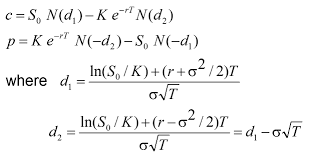

C : call option price

P : Put option price

S : Stock price

K : Strike price

r : risk free rate

t : time of maturity in year

N = Normal distribution

In [12]:
def euro_vanilla(S, K, T, r, sigma, option = 'call'):
    """
    To calculate options price with the help of black-scholes model

    Parameters
    ----------
    S : float
        The price of the underlying

    K : float
        Strike price of the option

    T : float
        Time to expiry in years

    r : float
        Risk free rate which can be taken as the US Treasury bond yield

    sigma : float
        The annual volatility of the returns

    option : string
        call for call option
        put for put option

    Returns
    -------
    premium : float
        The price of call or put option
    """


    d1 = (np.log(S/K) + (r + sigma**2 / 2) * T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    if option == 'call':
      premium = S * ss.norm.cdf(d1) - K * np.exp(-r * T) * ss.norm.cdf(d2)
    if option == 'put':
      premium =  K * np.exp(-r * T) * ss.norm.cdf(-d2) - S * ss.norm.cdf(-d1)

    return premium

In [13]:
N = 100
T = 8.0/365      #Calculate the number of days left for expiry from your calculation in years
t = T/N

In [14]:
#r is the risk free rate taken from the 10 years us treasury bond
#call price calculated from black scholes model
call = {}
for K in dfo_exp.calls['strike']:
    call_price = euro_vanilla(S = df['Close'][len(df)-1], K = K, T = T, r=0.0123*t, sigma=vol)
  # print(call_price)
    call[K] = call_price
th_call = pd.DataFrame.from_dict(call, orient='index')
th_call.rename(columns = {0:"th_call"}, inplace = True)
th_call.head()

,th_call
3850.0,847.240462
3900.0,797.240465
3950.0,747.240468
4300.0,397.280008
4340.0,357.360562


In [15]:
#actual call price
ac_call = dfo_exp.calls.loc[:, ['strike', 'lastPrice']]
ac_call.set_index('strike', inplace = True)
ac_call.rename(columns = {"lastPrice":"ac_call"}, inplace=True)
ac_call.head()

,ac_call
strike,
3850.0,733.83
3900.0,685.76
3950.0,636.41
4300.0,443.00
4340.0,371.43


In [16]:
call = th_call
call["ac_call"] = ac_call
call.head(10)

,th_call,ac_call
3850.0,847.240462,733.83
3900.0,797.240465,685.76
3950.0,747.240468,636.41
4300.0,397.280008,443.00
4340.0,357.360562,371.43
4350.0,347.396570,355.50
4370.0,327.499473,419.97
4375.0,322.533329,339.88
4380.0,317.571122,397.81
4390.0,307.660121,224.39


<Axes: >

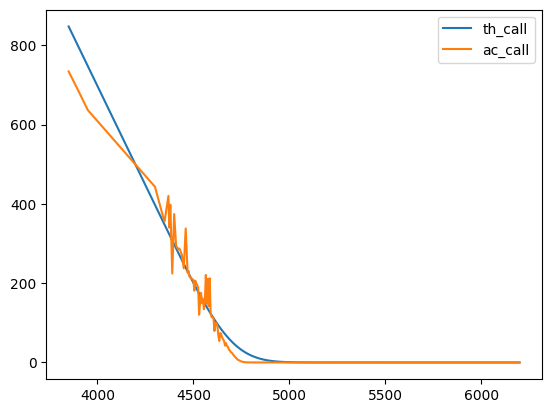

In [17]:
call.plot() #plotting the actual and theoretical call prices

In [18]:
#r is the risk free rate taken from the 10 years us treasury bond
#theoretical put price calculated from black scholes model
put = {}
for K in dfo_exp.puts['strike']:
    put_price = euro_vanilla(S = df['Close'][len(df)-1], K = K, T = T, r=0.0158*t, sigma=vol, option = 'put')
  # print(put_price)
    put[K] = put_price
th_put = pd.DataFrame.from_dict(put, orient='index')
th_put.rename(columns = {0:"th_put"}, inplace = True)
th_put.head()

,th_put
2000.0,2.089559e-192
2400.0,1.428946e-119
2800.0,1.767564e-71
3000.0,5.969818e-54
3200.0,8.739921e-40


In [19]:
#actual put price
ac_put = dfo_exp.puts.loc[:, ['strike', 'lastPrice']]
ac_put.set_index('strike', inplace = True)
ac_put.rename(columns = {"lastPrice":"ac_put"}, inplace=True)
ac_put.head()

,ac_put
strike,
2000.0,0.05
2400.0,0.07
2800.0,0.05
3000.0,0.05
3200.0,0.05


In [20]:
put = th_put
put["ac_put"] = ac_put
put.tail(10)

,th_put,ac_put
4925.0,230.680393,130.02
4950.0,254.660704,243.70
4975.0,278.969468,260.72
5000.0,303.512360,423.80
5025.0,328.217459,278.34
5050.0,353.031831,256.38
5100.0,402.849458,398.33
5200.0,502.766905,606.50
5400.0,702.759374,810.65
5800.0,1102.759325,1064.16


<Axes: >

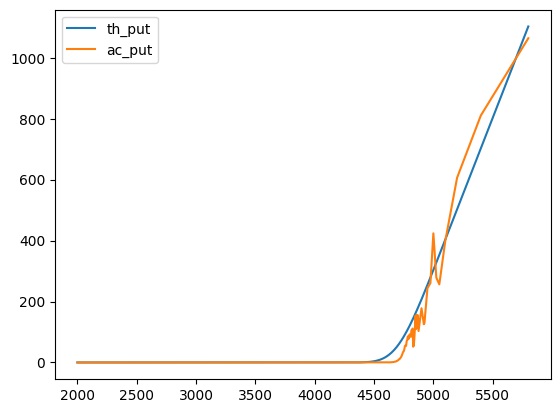

In [21]:
put.plot()